<h1 align="center">PNICER demonstration notebook</h1> 


## Preparations

**PNICER** main dependencies are *astropy*, *numpy*, and *scikit-learn*. In addition also *matplotlib* and *wcsaxes* are required for extended functionality

In [1]:
import sys
import numpy as np

from astropy.io import fits
from astropy.coordinates import SkyCoord
from pnicer import Magnitudes
from pnicer.utils import get_resource_path

%matplotlib inline

## Define file paths and load data

The implementation requires the data to be parsed in lists of arrays. Here we load coordinates, magnitudes, and errors for both the science and the control field.

In [6]:
# ----------------------------------------------------------------------
# Find the test files included in the package
science_path = get_resource_path(package="pnicer.tests_resources", resource="Orion_A_2mass.fits")
control_path = get_resource_path(package="pnicer.tests_resources", resource="CF_2mass.fits")


# ----------------------------------------------------------------------
# Define feature names and extinction vector
feature_names = ["Jmag", "Hmag", "Kmag"]
error_names = ["e_Jmag", "e_Hmag", "e_Kmag"]
extvec = [2.5, 1.55, 1.0]  # Indebetouw et al. 2015


# ----------------------------------------------------------------------
# Load data
with fits.open(science_path) as sci, fits.open(control_path) as con:

    science = sci[1].data
    control = con[1].data

    # Coordinates
    science_coo = SkyCoord(l=science["GLON"], b=science["GLAT"], frame="galactic", unit="deg", equinox="J2000")
    control_coo = SkyCoord(l=control["GLON"], b=control["GLAT"], frame="galactic", unit="deg", equinox="J2000")

    # Photometry
    science_phot, control_phot = [science[n] for n in feature_names], [control[n] for n in feature_names]

    # Errors
    science_err, control_err = [science[n] for n in error_names], [control[n] for n in error_names]

## **PNICER** Initialization

The **PNICER** package includes also includes a **NICER** implementation (Lombardi & Alves 2001). The data can be initialized as a *Magnitudes* instance. Alternativley also a *Colors* instance can be used. A *Colors* instance can also be created from a *Magnitudes* instance which calculates consecutive colors for the input data. While for *Magnitudes*, the parameter space will be spanned by magnitudes, *Colors* calculates the probability density in color space.

For the initialization we need the photometry and errors, as well as the extinction vector defined above. Alternativley, we can also specify feature names and coordinates.

In [3]:
science = Magnitudes(mag=science_phot, err=science_err, extvec=extvec, coordinates=science_coo, names=feature_names)
control = Magnitudes(mag=control_phot, err=control_err, extvec=extvec, coordinates=control_coo, names=feature_names)

**PNICER** includes a convenience method to convert to color space:

In [4]:
science_color = science.mag2color()
control_color = control.mag2color()

## Plotting methods

**PNICER** also includes a set of plotting methods, which help to visualize the data. One, for instance, may first like to look at the density distribution for the feature combinations:

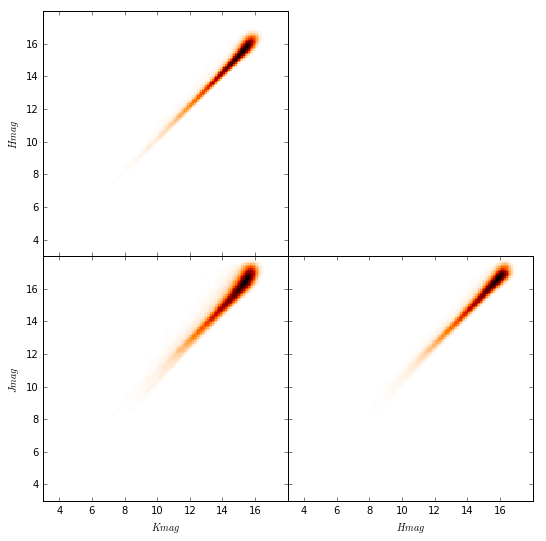

In [5]:
science.plot_combinations_kde()

We can do the same plot in color space with the instances created before:

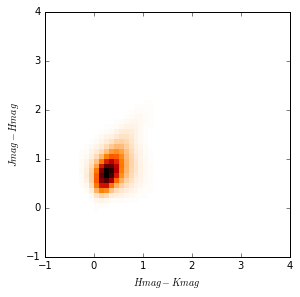

In [26]:
science.mag2color().plot_combinations_kde()

Also, it is very useful to look at the spatial distribution of sources. With the following plotting method we can display a kernel density map of all input features.

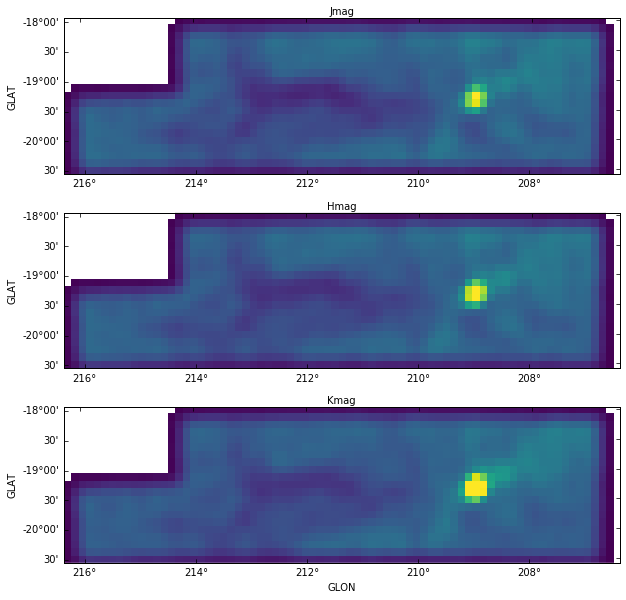

In [31]:
science.plot_sources_kde(bandwidth=15/60)

## Estimating extinction

Now that we had a look at our data, it is time to calculate color-excesses. The software package offers both the new **PNICER** method, as well as a **NICER** implementation. Running them is very simple:

In [32]:
ext_pnicer = science.pnicer(control=control)
ext_nicer = science.nicer(control=control)

We must note a few things here:

+ **NICER** can only be run with a *Magnitudes* instance, since the individual photometric errors are used
+ **PNICER** can run on both *Magnitudes* and *Colors* instances as long as you know the extinction vector for the components

Both calculations return and *Extinction* instance from which further options are available. We can save the data in a FITS table if we want:

In [33]:
ext_pnicer.save_fits(path="/tmp/temp.fits")

Or we can directly access the extinction for each source. The unit of this output is defined in the extinction vector above. In our case, the extinction vector was normalized to 1 in K band. Thus, the results are directly given in A_K.

In [38]:
ext_pnicer.extinction

array([-0.22051491,  0.43194761,  0.1239372 , ..., -0.01754672,
        0.38995289,  0.003558  ])

## Extinction map

The *Extinction* instance we got above can now also be used to calculate and extinction map. For this, various options are available

In [39]:
pnicer_emap = ext_pnicer.build_map(bandwidth=5 / 60, metric="gaussian", sampling=2, nicest=False, use_fwhm=True)

The methods above returns an *ExtinctionMap* instance, which again can be used for various subsequent tasks. We can save the data as a FITS image:

In [41]:
pnicer_emap.save_fits(path="/tmp/temp.fits")

Note that this already includes an autmaically calculated astrometric projection. We can also display the results with a convenient plotting method:

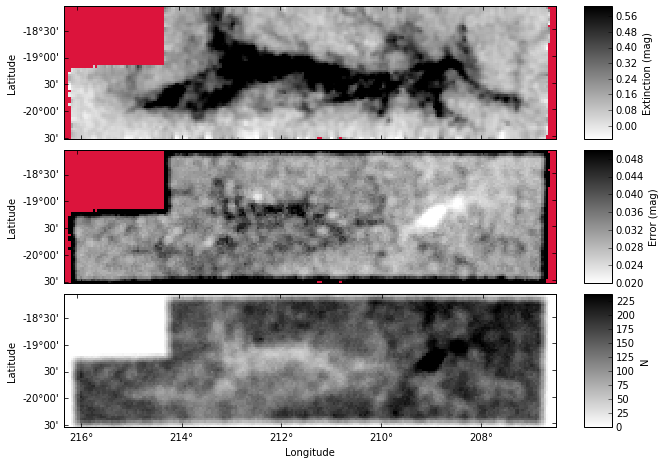

In [45]:
pnicer_emap.plot_map(figsize=10)

The red background here refers to pixels where not enough sources are available. These are the basics of **PNICER/NICER**. Happy hunting for extinction! :)